<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Data Visualization</center>

# Challenge S3: Prophet 
# Planificación de escenarios a futuro post-confinamiento en Retail

Tenemos las ventas de todas las tiendas de una cadena de retail en una serie de categorías desde principios de 2018 hasta que acabó el confinamiento estricto y queremos hacer un análisis del impacto que ha tenido en las distintas categorías y plantear escenarios a futuro en caso de haber alguna vuelta al confinamiento.

Teniendo esta valiosa información podríamos mejorar el stockage de los productos de las distintas categorías y poder reaccionar rápido en cuanto se anunciasen las nuevas medidas para poder amoldar espacios en los distintos almacenes de las tiendas y los pedidos en las distintas categorías en base a los distintos escenarios que podamos proponer.

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Cargar las ventas en un DataFrame

In [2]:
df_datos_categorias = pd.read_csv('Tabla Ventas Cats.csv',delimiter = ';')
df_datos_categorias['Fecha'] = pd.to_datetime(df_datos_categorias['Fecha'], format='%Y-%m-%d')
df_datos_categorias.tail()

,Fecha,Categoría,Unidades,Ventas
14865,2020-05-31,Yogurt saludable,4.000,8.56
14866,2020-05-31,Papel higiénico,3.000,8.99
14867,2020-05-31,Patatas,2.000,7.18
14868,2020-05-31,Naranjas,9.475,25.25
14869,2020-05-31,Tabletas de chocolate,7.000,8.96


In [3]:
df_datos_categorias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14870 entries, 0 to 14869
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha      14870 non-null  datetime64[ns]
 1   Categoría  14870 non-null  object        
 2   Unidades   14870 non-null  float64       
 3   Ventas     14870 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 464.8+ KB


## 2. Exploración de los datos

** P. ¿ Cuál es el inicio y el final de datos ? **

In [4]:
#Los datos pertenecen a una serie temporal diaria, que se represena en la columna fecha
print('El inicio de los datos es : ',str(df_datos_categorias['Fecha'].describe(datetime_is_numeric=True).loc['min']))
print('El final de los datos es : ',str(df_datos_categorias['Fecha'].describe(datetime_is_numeric=True).loc['max']))

El inicio de los datos es :  2018-01-01 00:00:00
El final de los datos es :  2020-05-31 00:00:00


** P ¿ De qué categorías tenemos venta ? **

In [5]:
cats = df_datos_categorias['Categoría'].unique()
print('Las categorias de productos son : ',str(cats))

Las categorias de productos son :  ['Aguas sin gas' 'Cervezas con alcohol' 'Colas' 'Utensilios de cocina'
 'Frutos secos' 'Leche' 'Huevos' 'Pizza congelada' 'Pasta'
 'Caldos y cremas líquidas' 'Yogurt saludable' 'Barras de pan baguette'
 'Barras de pan rústico' 'Papel higiénico' 'Patatas' 'Naranjas'
 'Tabletas de chocolate']


## 3. Obtención de la mejor y peor categoría en los distintos trimestres y lo que llevamos de semestre

Vamos a obtener un dataframe con el comportamiento de las distintas categorías en cuanto a variación porcentual de ventas para el Q1, Q2 y lo que llevamos de S1, es decir hasta el 31 de Mayo.

%Var = ((Vactuales/Vanteriores) - 1 ) * 100

In [6]:
# Lo primero que realizamos es seleccionar el rango de fechas desde 1 de enero al 31 de Mayo tanto de 2019 como de 2020
# para poder hacer las comparaciones de Trimestres y Semestres

df_categorias_trimestre = df_datos_categorias.copy()
df_categorias_trimestre = df_categorias_trimestre[((df_categorias_trimestre['Fecha'] >= '2019-01-01') &
    (df_categorias_trimestre['Fecha'] <= '2019-05-31'))|((df_categorias_trimestre['Fecha'] >= '2020-01-01') &
    (df_categorias_trimestre['Fecha'] <= '2020-05-31'))]
df_categorias_trimestre.reset_index(drop=True)


,Fecha,Categoría,Unidades,Ventas
0,2019-01-02,Aguas sin gas,17294.000,9804.197398
1,2019-01-02,Cervezas con alcohol,9273.000,8265.329593
2,2019-01-02,Colas,5207.000,5491.240018
3,2019-01-02,Utensilios de cocina,14796.550,1284.260003
4,2019-01-02,Frutos secos,2619.000,4989.990017
...,...,...,...,...
5075,2020-05-31,Yogurt saludable,4.000,8.560000
5076,2020-05-31,Papel higiénico,3.000,8.990000
5077,2020-05-31,Patatas,2.000,7.180000
5078,2020-05-31,Naranjas,9.475,25.250000


In [7]:
#Para trabajar de mejorforma creamos una pivot table
df_categorias_trimestre_pivot = pd.pivot_table(df_categorias_trimestre, values='Ventas', index=['Fecha'],
                     columns=['Categoría'],aggfunc='sum',fill_value=0)
#Hacemos resample por Q para agragar por trimestres
df_categorias_trimestre_pivot=df_categorias_trimestre_pivot.resample('Q').sum()
#Invertimos la tabla para poder trabajar de forma más facil. Ahora las columnas son los cuatrimestres
df_categorias_trimestre_definitivo=df_categorias_trimestre_pivot.T
df_categorias_trimestre_definitivo

Fecha,2019-03-31,2019-06-30,2019-09-30,2019-12-31,2020-03-31,2020-06-30
Categoría,,,,,,
Aguas sin gas,776472.270241,537099.648818,0.0,0.0,872556.949030,592433.690673
Barras de pan baguette,285168.096280,181609.857727,0.0,0.0,263281.312145,128176.310927
Barras de pan rústico,283131.890287,180212.230154,0.0,0.0,301446.149342,170695.379696
Caldos y cremas líquidas,397903.909671,234485.700121,0.0,0.0,508167.450737,284093.630278
Cervezas con alcohol,829198.847566,627468.666750,0.0,0.0,991761.341617,952263.763707
Colas,485330.242750,345058.280407,0.0,0.0,549116.765949,424605.087285
Frutos secos,465981.119324,318191.091107,0.0,0.0,571712.980812,478862.880106
Huevos,417245.359484,291120.731659,0.0,0.0,534872.902212,413893.796794
Leche,723471.018333,462372.450277,0.0,0.0,832672.938047,561714.627866


In [8]:
#Nos quedamos con las columnas de os cuatrimestres
df_categorias_trimestre_definitivo=df_categorias_trimestre_definitivo[['2019-03-31','2019-06-30','2020-03-31','2020-06-30']]
df_categorias_trimestre_definitivo

Fecha,2019-03-31,2019-06-30,2020-03-31,2020-06-30
Categoría,,,,
Aguas sin gas,776472.270241,537099.648818,872556.949030,592433.690673
Barras de pan baguette,285168.096280,181609.857727,263281.312145,128176.310927
Barras de pan rústico,283131.890287,180212.230154,301446.149342,170695.379696
Caldos y cremas líquidas,397903.909671,234485.700121,508167.450737,284093.630278
Cervezas con alcohol,829198.847566,627468.666750,991761.341617,952263.763707
Colas,485330.242750,345058.280407,549116.765949,424605.087285
Frutos secos,465981.119324,318191.091107,571712.980812,478862.880106
Huevos,417245.359484,291120.731659,534872.902212,413893.796794
Leche,723471.018333,462372.450277,832672.938047,561714.627866


In [9]:
#Función que aplica la formula de la variación de las ventas. Y calcula los semestres apartir de los trimestres.
def calculo_variaciones (row,ant,act):
    #Calculamos los semestres como suma de los 2 Q que tenemos
    row['S1_'+ant]=row[0]+row[1]
    row['S1_'+act]=row[2]+row[3]
    #Calculamos variaciones
    row['Var_Q1_'+ant+'_'+act]=((row[2]/row[0])-1)*100 
    row['Var_Q2_'+ant+'_'+act]=((row[3]/row[1])-1)*100 
    row['Var_S1_'+ant+'_'+act]=((row['S1_'+act]/row['S1_'+ant])-1)*100
    return row

In [10]:
df_categorias_variaciones=df_categorias_trimestre_definitivo.apply(calculo_variaciones,ant='19',act='20',axis=1)

In [11]:
df_categorias_variaciones

Fecha,2019-03-31 00:00:00,2019-06-30 00:00:00,2020-03-31 00:00:00,2020-06-30 00:00:00,S1_19,S1_20,Var_Q1_19_20,Var_Q2_19_20,Var_S1_19_20
Categoría,,,,,,,,,
Aguas sin gas,776472.270241,537099.648818,872556.949030,592433.690673,1.313572e+06,1.464991e+06,12.374515,10.302379,11.527250
Barras de pan baguette,285168.096280,181609.857727,263281.312145,128176.310927,4.667780e+05,3.914576e+05,-7.675047,-29.422162,-16.136223
Barras de pan rústico,283131.890287,180212.230154,301446.149342,170695.379696,4.633441e+05,4.721415e+05,6.468455,-5.280913,1.898677
Caldos y cremas líquidas,397903.909671,234485.700121,508167.450737,284093.630278,6.323896e+05,7.922611e+05,27.711098,21.156058,25.280534
Cervezas con alcohol,829198.847566,627468.666750,991761.341617,952263.763707,1.456668e+06,1.944025e+06,19.604766,51.762760,33.457023
Colas,485330.242750,345058.280407,549116.765949,424605.087285,8.303885e+05,9.737219e+05,13.142911,23.053151,17.260996
Frutos secos,465981.119324,318191.091107,571712.980812,478862.880106,7.841722e+05,1.050576e+06,22.690160,50.495376,33.972595
Huevos,417245.359484,291120.731659,534872.902212,413893.796794,7.083661e+05,9.487667e+05,28.191456,42.172560,33.937340
Leche,723471.018333,462372.450277,832672.938047,561714.627866,1.185843e+06,1.394388e+06,15.094166,21.485315,17.586140


In [12]:
df_categorias_variaciones=df_categorias_variaciones.loc[:,['Var_Q1_19_20','Var_Q2_19_20','Var_S1_19_20']]
df_categorias_variaciones.sort_values(by='Var_S1_19_20', ascending=False)

Fecha,Var_Q1_19_20,Var_Q2_19_20,Var_S1_19_20
Categoría,,,
Naranjas,29.203064,110.698487,61.892433
Utensilios de cocina,65.617341,52.178302,59.936156
Frutos secos,22.690160,50.495376,33.972595
Huevos,28.191456,42.172560,33.937340
Cervezas con alcohol,19.604766,51.762760,33.457023
Tabletas de chocolate,19.314632,44.977860,29.751283
Papel higiénico,40.846754,12.009556,29.326557
Patatas,25.692084,28.779281,27.006079
Caldos y cremas líquidas,27.711098,21.156058,25.280534


* Las **Naranajas** son la mejor catagoría y las **Barras de pan baguette**

## 4. Visualización de mejor y peor categoría en el S1

En función a la mejor y peor categoría en cuanto a % de variación de ventas que hayas obtenido en el apartado anterior, haz un ploteo de ambas categorías filtradas para ver cómo ha sido visualmente ese impacto y que veamos que puntos hay interesantes.

En primer lugar sería interesante plotear el primer año de ventas para ver la estacionalidad que tenía o el comportamiento normal de esta serie temporal por así decirlo y luego vamos a ver el comportamiento en lo que llevamos de 2020 para identificar anomalías.

#### Mejor categoría

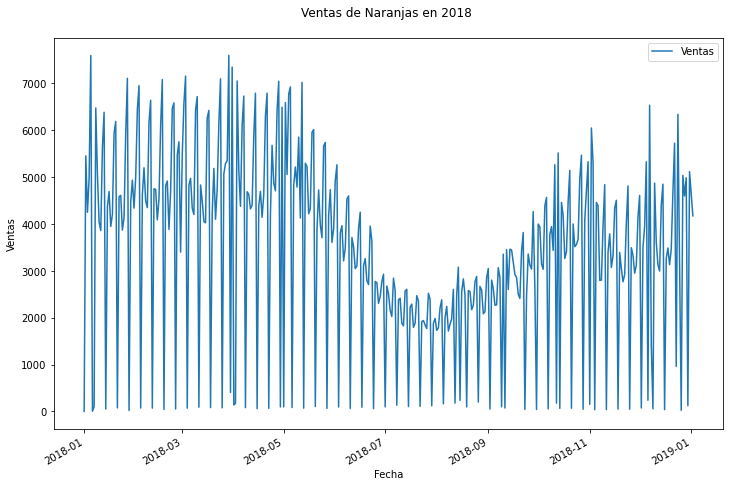

In [13]:
## Representamos nuestra serie temporal para el primer año
df_datos_categorias_mejor=df_datos_categorias[df_datos_categorias['Categoría']=='Naranjas'].loc[:,['Fecha','Ventas']].reset_index(drop=True)
ax = df_datos_categorias_mejor.iloc[:364].set_index('Fecha').plot(figsize = (12, 8),
                                      title = 'Ventas de Naranjas en 2018 \n')
ax.set_ylabel('Ventas')
ax.set_xlabel('Fecha')

plt.show()

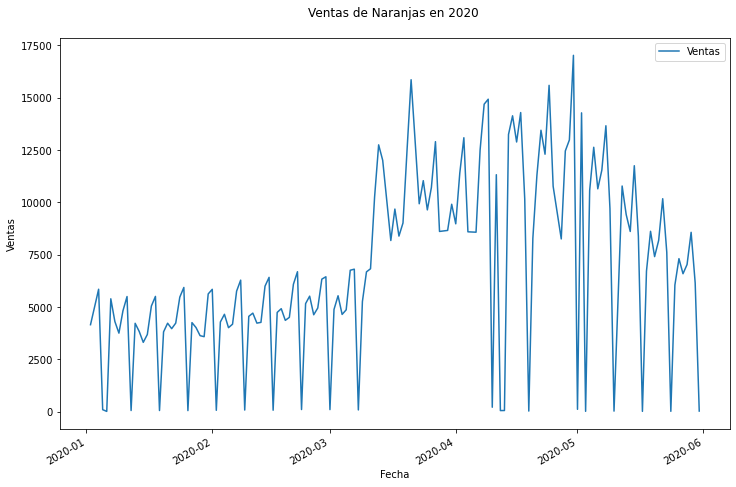

In [14]:
## Representamos nuestra serie temporal para 2020
ax = df_datos_categorias_mejor.iloc[726:].set_index('Fecha').plot(figsize = (12, 8),
                                      title = 'Ventas de Naranjas en 2020 \n')
ax.set_ylabel('Ventas')
ax.set_xlabel('Fecha')

plt.show()


#### Peor categoría

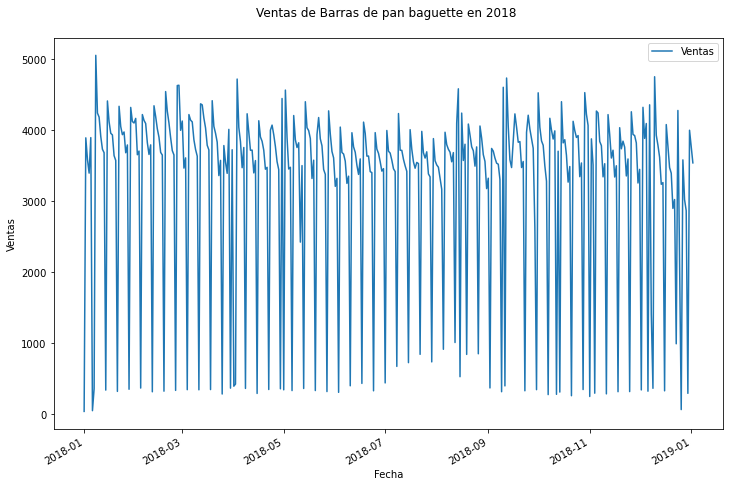

In [15]:
## Representamos nuestra serie temporal para el primer año
df_datos_categorias_peor=df_datos_categorias[df_datos_categorias['Categoría']=='Barras de pan baguette'].loc[:,['Fecha','Ventas']].reset_index(drop=True)
ax = df_datos_categorias_peor.iloc[:364].set_index('Fecha').plot(figsize = (12, 8),
                                      title = 'Ventas de Barras de pan baguette en 2018 \n')
ax.set_ylabel('Ventas')
ax.set_xlabel('Fecha')

plt.show()

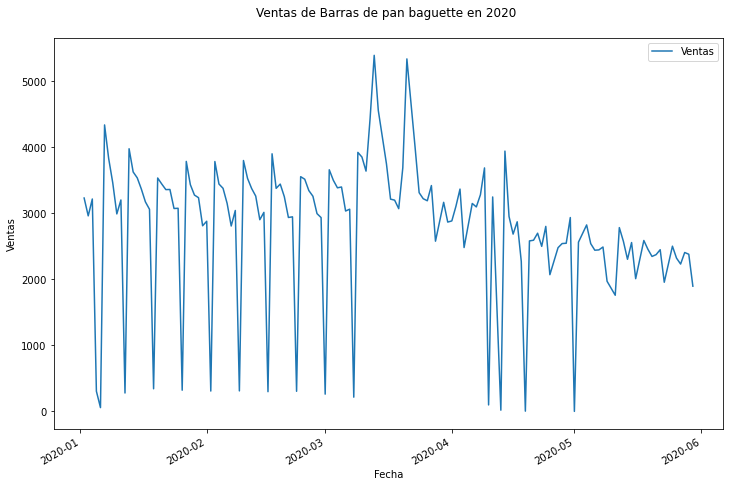

In [16]:
## Representamos nuestra serie temporal para 2020
ax = df_datos_categorias_peor.iloc[726:].set_index('Fecha').plot(figsize = (12, 8),
                                      title = 'Ventas de Barras de pan baguette en 2020 \n')
ax.set_ylabel('Ventas')
ax.set_xlabel('Fecha')

plt.show()

## 5. Realizar una previsión simple sobre las ventas en 2021

En este primer paso se trata de realizar una primera predicción de las ventas de una categoría en concreto hasta el final de 2021, vamos a ver como reacciona el modelo sin añadir ningún tipo de holiday para ver la interpretación del mismo cuando no le damos ningún otro tipo de input.

Para una primera aproximación vamos a coger la categoría con mejor evolución de ventas.

In [17]:
#Preparamos el dataframe para Prophet
df_datos_categorias_mejor = df_datos_categorias[df_datos_categorias['Categoría']=='Naranjas'].loc[:,['Fecha','Ventas']].reset_index(drop=True)
df_datos_categorias_mejor = df_datos_categorias_mejor.rename(columns={'Fecha': 'ds', 'Ventas': 'y'})
df_datos_categorias_mejor

,ds,y
0,2018-01-01,1.890000
1,2018-01-02,5454.980826
2,2018-01-03,4249.981477
3,2018-01-04,4981.092628
4,2018-01-05,7594.093859
...,...,...
867,2020-05-27,6586.670017
868,2020-05-28,7026.790011
869,2020-05-29,8565.650021
870,2020-05-30,6147.320011


In [18]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(df_datos_categorias_mejor)
futuro = modelo.make_future_dataframe(periods=579)
futuro.tail()

,ds
1446,2021-12-27
1447,2021-12-28
1448,2021-12-29
1449,2021-12-30
1450,2021-12-31


In [19]:
prevision = modelo.predict(futuro)
prevision.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1446,2021-12-27,18241.115587,18272.097557,24084.159194,15883.977492,20469.046031,2942.231056,2942.231056,2942.231056,2897.5089,...,115.191173,115.191173,115.191173,-70.469017,-70.469017,-70.469017,0.0,0.0,0.0,21183.346643
1447,2021-12-28,18264.559669,18690.016688,24865.007059,15897.150195,20497.165341,3450.264809,3450.264809,3450.264809,2897.5089,...,598.619436,598.619436,598.619436,-45.863527,-45.863527,-45.863527,0.0,0.0,0.0,21714.824477
1448,2021-12-29,18288.003751,18118.815433,24306.668900,15911.699879,20525.284650,2969.846987,2969.846987,2969.846987,2897.5089,...,93.222278,93.222278,93.222278,-20.884191,-20.884191,-20.884191,0.0,0.0,0.0,21257.850738
1449,2021-12-30,18311.447832,18564.019151,24442.299127,15927.705024,20553.403960,3204.774776,3204.774776,3204.774776,2897.5089,...,303.195128,303.195128,303.195128,4.070748,4.070748,4.070748,0.0,0.0,0.0,21516.222608
1450,2021-12-31,18334.891914,19448.440968,25421.898527,15943.719547,20581.523270,4056.346933,4056.346933,4056.346933,2897.5089,...,1130.233014,1130.233014,1130.233014,28.605018,28.605018,28.605018,0.0,0.0,0.0,22391.238847


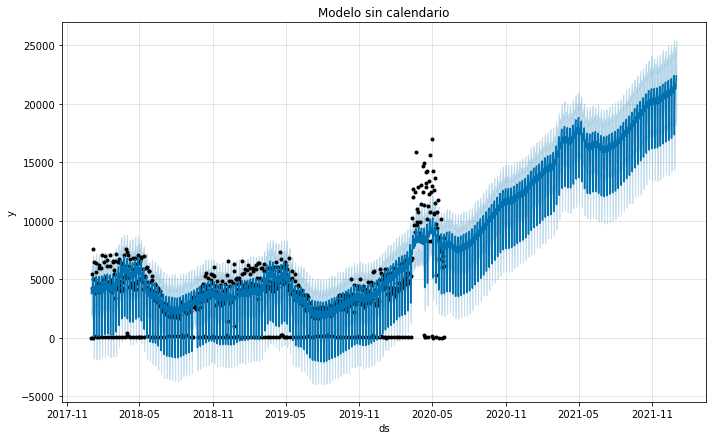

In [20]:
modelo.plot(prevision);
plt.gca().set_title('Modelo sin calendario');

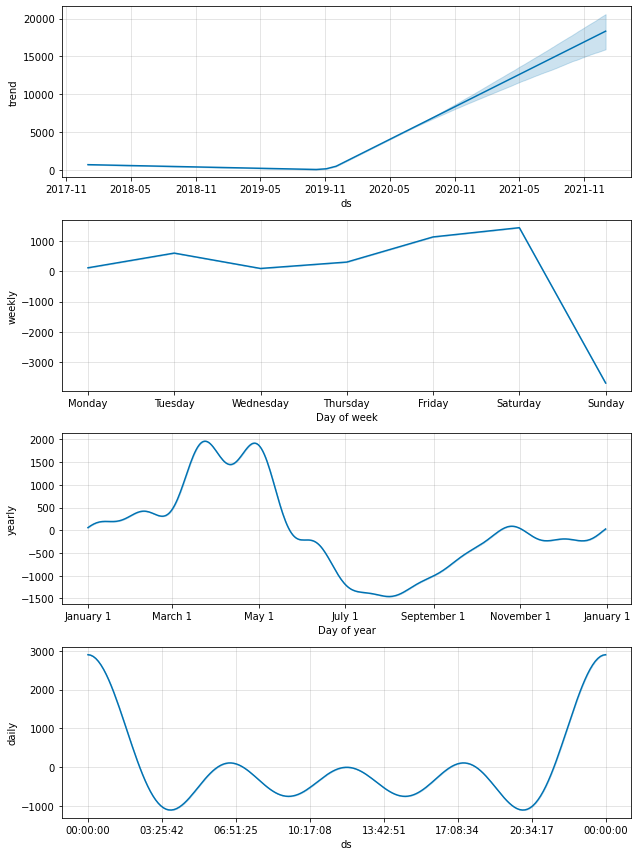

In [21]:
modelo.plot_components(prevision, weekly_start = 1);

** P ¿ Están bien nuestras predicciones ? ** Fíjate en la estacionalidad anual donde presenta un pico, ¿ ha habido alguna influencia puntual que haya podido influenciar en este cálculo ?

* Revisando la estacionalidad anual hay un fuerte repunte o pico de ventas. Comprende las fechas del confinamiento duro de COVID entre Marzo y finales de Mayo principio de Junio de 2020

## 6. Mejorar nuestro modelo de previsión incluyendo algún evento especial.

Incluya una lista de holidays que sea interesante con sus distintos tags para que el modelo separe mejor que contribuciones vienen por la propia estacionalidad o por eventos externos.

Tener en cuenta todo este tipo de eventos sólo en el ámbito temporal de entrenamiento (del que tenemos datos), no lo proyectéis a futuro aún.


In [22]:
# Confinamiento COVID https://es.wikipedia.org/wiki/Confinamiento_por_la_pandemia_de_COVID-19_en_Espa%C3%B1a

#En 2020 no consideramos dias especiales de semana santa ya que se incluye dentro del periodo de confinamiento.
semanasanta = pd.DataFrame({
  'holiday': 'semanasanta',
  'ds': pd.to_datetime(['2018-03-28','2018-03-29', '2018-03-30',
                        '2018-04-01','2018-04-02', '2019-04-18',
                        '2019-04-19','2019-04-20', '2019-04-21',
                        '2019-04-22']),
  'lower_window': 0,
  'upper_window': 1,
})

confinamiento = pd.DataFrame({
  'holiday': 'confinamiento',
  'ds': pd.to_datetime(['2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18',
               '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30',
               '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03',
               '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07',
               '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11',
               '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15',
               '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
               '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23',
               '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27',
               '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01',
               '2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05',
               '2020-05-06', '2020-05-07', '2020-05-08', '2020-05-09',
               '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13',
               '2020-05-14', '2020-05-15', '2020-05-16', '2020-05-17',
               '2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21',
               '2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25',
               '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29',
               '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02',
               '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06',
               '2020-06-07', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14',
               '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18',
               '2020-06-19', '2020-06-20', '2020-06-21']),
  'lower_window': 0,
  'upper_window': 1,
})


cierres_perimterales_puente_dic_2020 = pd.DataFrame({
  'holiday': 'cierres',
  'ds': pd.to_datetime(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15']),
  'lower_window': 0,
  'upper_window': 1,
})

semanasanta_2021 = pd.DataFrame({
  'holiday': 'semanasanta',
  'ds': pd.to_datetime(['2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04','2021-04-05']),
  'lower_window': 0,
  'upper_window': 1,
})


In [23]:
pd.date_range(start='2020-12-01', end='2020-12-15')

DatetimeIndex(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15'],
              dtype='datetime64[ns]', freq='D')

In [24]:
dias_especiales = pd.concat((semanasanta, confinamiento,cierres_perimterales_puente_dic_2020,semanasanta_2021))
dias_especiales

,holiday,ds,lower_window,upper_window
0,semanasanta,2018-03-28,0,1
1,semanasanta,2018-03-29,0,1
2,semanasanta,2018-03-30,0,1
3,semanasanta,2018-04-01,0,1
4,semanasanta,2018-04-02,0,1
...,...,...,...,...
0,semanasanta,2021-04-01,0,1
1,semanasanta,2021-04-02,0,1
2,semanasanta,2021-04-03,0,1
3,semanasanta,2021-04-04,0,1


In [25]:
dias_especiales = dias_especiales.reset_index()
modelo2 = Prophet(holidays=dias_especiales,daily_seasonality=True)
modelo2.fit(df_datos_categorias_mejor)
futuro2 = modelo2.make_future_dataframe(periods=579)
futuro.tail()

,ds
1446,2021-12-27
1447,2021-12-28
1448,2021-12-29
1449,2021-12-30
1450,2021-12-31


In [26]:
prevision2 = modelo2.predict(futuro2)
prevision2.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,cierres,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1446,2021-12-27,754.505005,2072.575889,5587.881355,680.321193,820.524617,3106.993259,3106.993259,3106.993259,0.0,...,105.893485,105.893485,105.893485,205.946464,205.946464,205.946464,0.0,0.0,0.0,3861.498263
1447,2021-12-28,754.786154,2592.264635,6201.726302,680.489412,821.020681,3607.405907,3607.405907,3607.405907,0.0,...,581.001480,581.001480,581.001480,231.251118,231.251118,231.251118,0.0,0.0,0.0,4362.192060
1448,2021-12-29,755.067303,2149.697503,5687.002855,680.657431,821.516745,3117.954966,3117.954966,3117.954966,0.0,...,66.172928,66.172928,66.172928,256.628729,256.628729,256.628729,0.0,0.0,0.0,3873.022268
1449,2021-12-30,755.348452,2250.402433,5912.036551,680.729371,822.012810,3380.707300,3380.707300,3380.707300,0.0,...,303.652312,303.652312,303.652312,281.901679,281.901679,281.901679,0.0,0.0,0.0,4136.055752
1450,2021-12-31,755.629601,3210.100602,6796.990059,680.801312,822.508874,4243.616173,4243.616173,4243.616173,0.0,...,1141.568334,1141.568334,1141.568334,306.894530,306.894530,306.894530,0.0,0.0,0.0,4999.245774


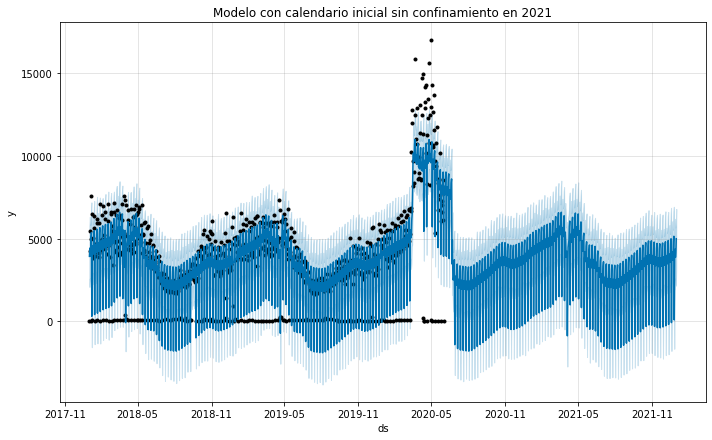

In [27]:
modelo2.plot(prevision2);
plt.gca().set_title('Modelo con calendario inicial sin confinamiento en 2021');

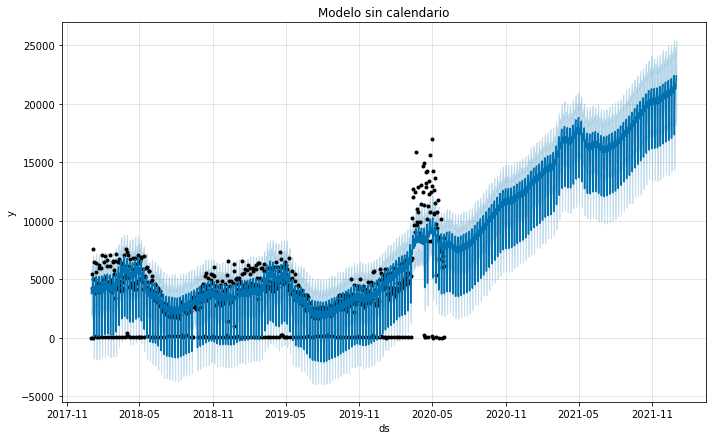

In [28]:
#Modelo anterior sin calendario
modelo.plot(prevision);
plt.gca().set_title('Modelo sin calendario');

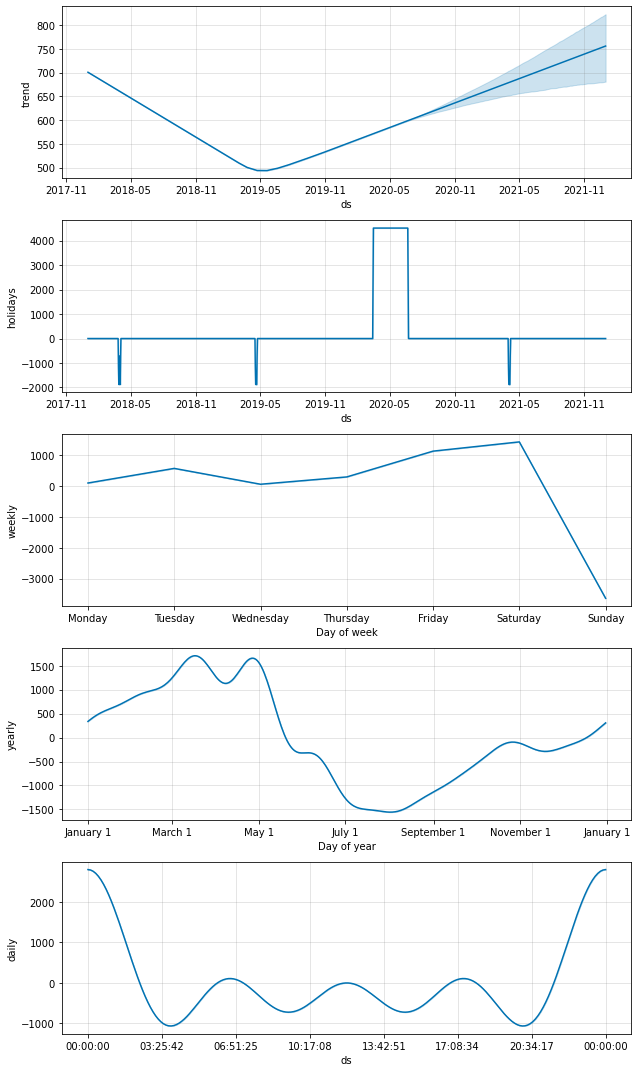

In [29]:
modelo2.plot_components(prevision2, weekly_start = 1);

## 7. Plantear distintos escenarios sobre un posible confinamiento y ver su impacto en las ventas (usando el % variación  de ventas entre trimestres)

Ya que hemos visto como el modelo se ha modificado en cuanto hemos señalado eventos externos que tenían cierta influencia sobre nuestra serie temporal se os pide que para la categoría que queráis, hagáis el entrenamiento del modelo y la predicción hasta 2021 teniendo en cuenta los efectos de todas estas variables externas y además incluirlos en vuestra predicción a futuro según distintos escenarios que tengáis en mente.

### Escenario 1 : Hay confinamiento a principios de 2021

In [30]:
# Confinamiento COVID https://es.wikipedia.org/wiki/Confinamiento_por_la_pandemia_de_COVID-19_en_Espa%C3%B1a

confinamiento_inicio_2021 = pd.DataFrame({
  'holiday': 'confinamiento',
  'ds': pd.to_datetime(['2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
               '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
               '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
               '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
               '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2021-03-06', '2021-03-07', '2021-03-08', '2021-03-09',
               '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13',
               '2021-03-14']),
  'lower_window': 0,
  'upper_window': 1,
})


In [31]:
#pd.date_range(start='2021-07-15', end='2021-09-15')

In [32]:
dias_especiales_incio_2021 = pd.concat((semanasanta, confinamiento,cierres_perimterales_puente_dic_2020,confinamiento_inicio_2021,semanasanta_2021))
dias_especiales_incio_2021

,holiday,ds,lower_window,upper_window
0,semanasanta,2018-03-28,0,1
1,semanasanta,2018-03-29,0,1
2,semanasanta,2018-03-30,0,1
3,semanasanta,2018-04-01,0,1
4,semanasanta,2018-04-02,0,1
...,...,...,...,...
0,semanasanta,2021-04-01,0,1
1,semanasanta,2021-04-02,0,1
2,semanasanta,2021-04-03,0,1
3,semanasanta,2021-04-04,0,1


In [33]:
dias_especiales_incio_2021 = dias_especiales_incio_2021.reset_index()

In [34]:
# modelo_2021_1 = Prophet(holidays=dias_especiales_incio_2021,daily_seasonality=True,weekly_seasonality=True)
modelo_2021_1 = Prophet(holidays=dias_especiales_incio_2021)
prevision_2021_1= modelo_2021_1.fit(df_datos_categorias_mejor)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


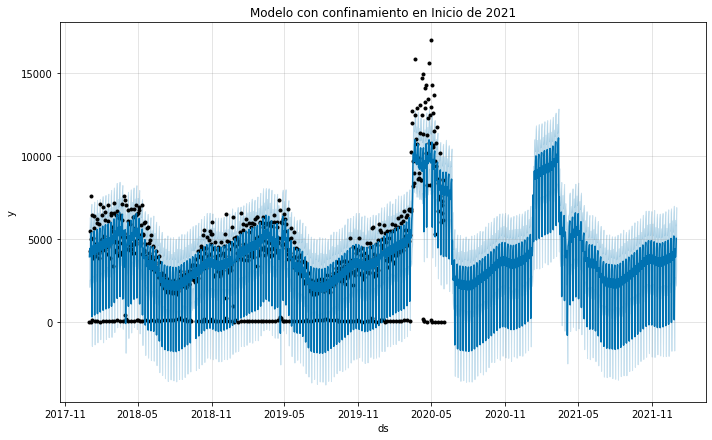

In [35]:
futuro3 = modelo_2021_1.make_future_dataframe(periods=579)
prevision_2021_1 = modelo_2021_1.predict(futuro3)
modelo_2021_1.plot(prevision_2021_1);
plt.gca().set_title('Modelo con confinamiento en Inicio de 2021');

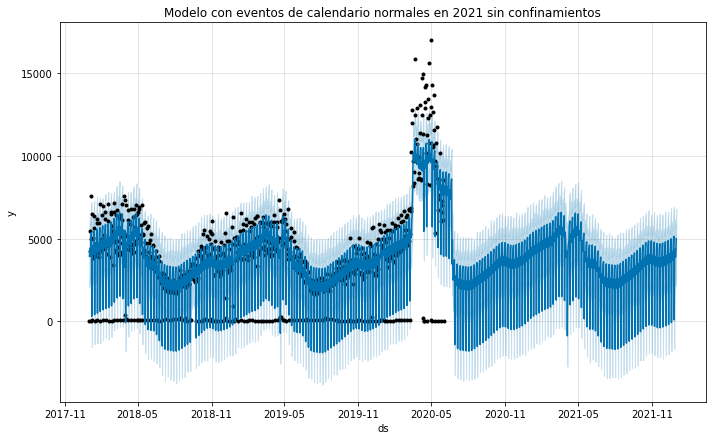

In [36]:
#Modelo con eventos de calendario normales sin confinamientos
modelo2.plot(prevision2);
plt.gca().set_title('Modelo con eventos de calendario normales en 2021 sin confinamientos');

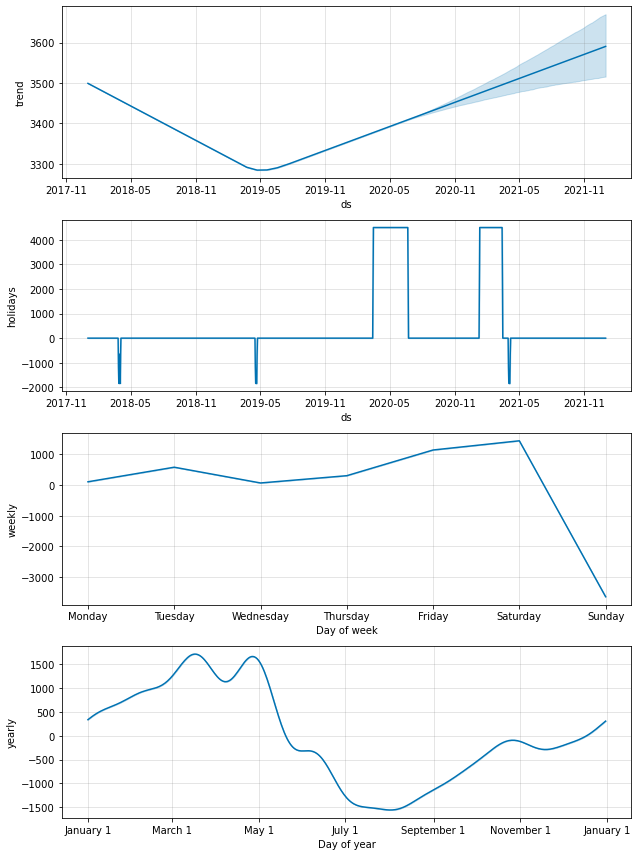

In [37]:
modelo_2021_1.plot_components(prevision_2021_1, weekly_start = 1);

### Escenario 2 : Hay confinamiento en verano de 2021 por una cepa nueva

In [38]:
confinamiento_verano_2021 = pd.DataFrame({
  'holiday': 'confinamiento',
  'ds': pd.to_datetime(['2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
               '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
               '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
               '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
               '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
               '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
               '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
               '2021-09-01', '2021-09-02', '2021-09-03', '2021-09-04',
               '2021-09-05', '2021-09-06', '2021-09-07', '2021-09-08',
               '2021-09-09', '2021-09-10', '2021-09-11', '2021-09-12',
               '2021-09-13', '2021-09-14', '2021-09-15']),
  'lower_window': 0,
  'upper_window': 1,
})

In [39]:
dias_especiales_verano_2021 = pd.concat((semanasanta, confinamiento,cierres_perimterales_puente_dic_2020,semanasanta_2021,confinamiento_verano_2021))
dias_especiales_verano_2021

,holiday,ds,lower_window,upper_window
0,semanasanta,2018-03-28,0,1
1,semanasanta,2018-03-29,0,1
2,semanasanta,2018-03-30,0,1
3,semanasanta,2018-04-01,0,1
4,semanasanta,2018-04-02,0,1
...,...,...,...,...
58,confinamiento,2021-09-11,0,1
59,confinamiento,2021-09-12,0,1
60,confinamiento,2021-09-13,0,1
61,confinamiento,2021-09-14,0,1


In [40]:
dias_especiales_verano_2021 = dias_especiales_verano_2021.reset_index()

In [41]:
# modelo_2021_2 = Prophet(holidays=dias_especiales_verano_2021,daily_seasonality=True,weekly_seasonality=True)
modelo_2021_2 = Prophet(holidays=dias_especiales_verano_2021)
modelo_2021_2.fit(df_datos_categorias_mejor)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


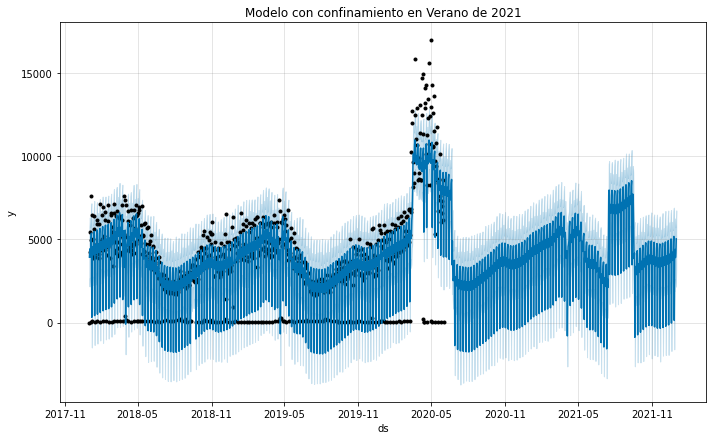

In [42]:
futuro4 = modelo_2021_2.make_future_dataframe(periods=579)
prevision_2021_2 = modelo_2021_2.predict(futuro4)
modelo_2021_2.plot(prevision_2021_2);
plt.gca().set_title('Modelo con confinamiento en Verano de 2021');

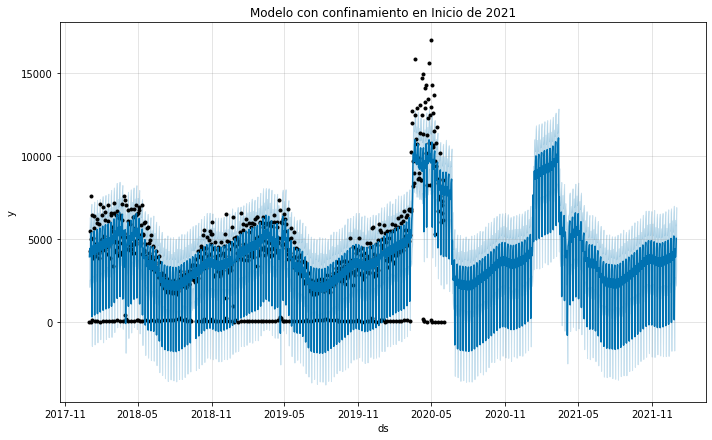

In [43]:
#Modelo con confinamiento en Inicio de 2021
modelo_2021_1.plot(prevision_2021_1);
plt.gca().set_title('Modelo con confinamiento en Inicio de 2021');

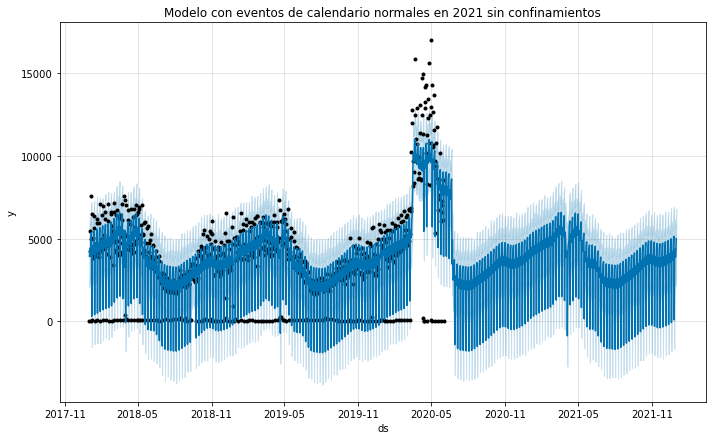

In [44]:
#Modelo con eventos de calendario normales en 2021 sin confinamientos
modelo2.plot(prevision2);
plt.gca().set_title('Modelo con eventos de calendario normales en 2021 sin confinamientos');

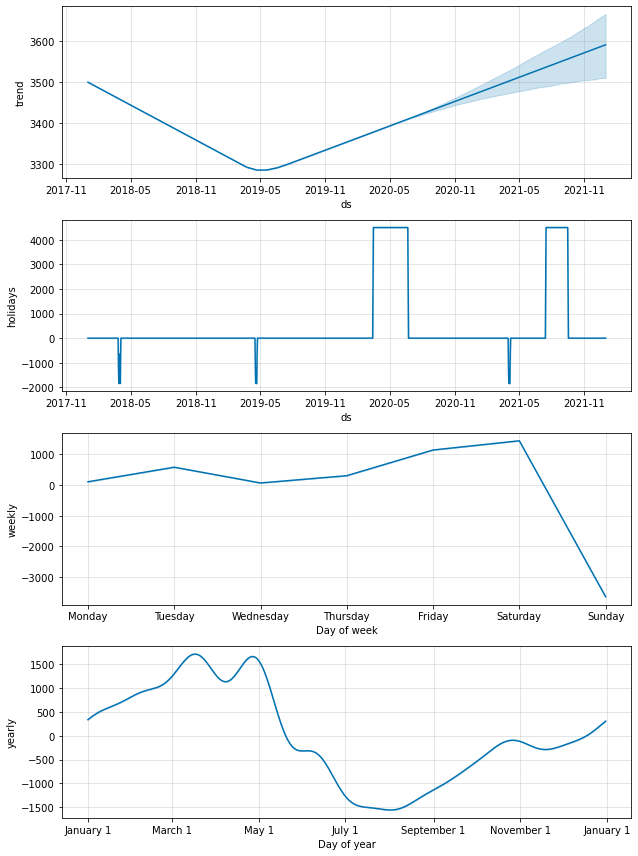

In [45]:
modelo_2021_2.plot_components(prevision_2021_2, weekly_start = 1);

## Comparativa % variación de ventas trimestrales 

#### Comparativa 2020 vs 2021 Escenario 1: Confinamiento inicio 2021

In [46]:
#Previsión con confinamiento en inicio 2021.
# Vemos como afecta el confinamiento
# prevision_2021_1.loc[:,['ds','yhat']]
prevision_2021_1[(prevision_2021_1['confinamiento']) != 0][
        ['ds', 'confinamiento', 'semanasanta']]

,ds,confinamiento,semanasanta
799,2020-03-16,4501.325221,0.0
800,2020-03-17,4501.325221,0.0
801,2020-03-18,4501.325221,0.0
802,2020-03-19,4501.325221,0.0
803,2020-03-20,4501.325221,0.0
...,...,...,...
1155,2021-03-11,4501.325221,0.0
1156,2021-03-12,4501.325221,0.0
1157,2021-03-13,4501.325221,0.0
1158,2021-03-14,4501.325221,0.0


In [47]:
#Vemos como afecta la semana santa
prevision_2021_1[(prevision_2021_1['semanasanta']) != 0][
        ['ds', 'confinamiento', 'semanasanta']]

,ds,confinamiento,semanasanta
86,2018-03-28,0.0,-1188.064675
87,2018-03-29,0.0,-1841.858875
88,2018-03-30,0.0,-1841.858875
89,2018-03-31,0.0,-653.794200
90,2018-04-01,0.0,-1188.064675
91,2018-04-02,0.0,-1841.858875
92,2018-04-03,0.0,-653.794200
469,2019-04-18,0.0,-1188.064675
470,2019-04-19,0.0,-1841.858875
471,2019-04-20,0.0,-1841.858875


In [48]:
#Seleccionamos los datos de del 1 de enero al 31 de Mayo para poder hacer la comparativa con 2020

df_comparativa_prophet=prevision_2021_1[((prevision_2021_1['ds'] >= '2021-01-01') &
    (prevision_2021_1['ds'] <= '2021-05-31'))].loc[:,['ds','yhat']]
df_comparativa_prophet = df_comparativa_prophet.rename(columns={'ds': 'Fecha', 'yhat': 'Ventas'})
df_comparativa_prophet['Categoría']='Naranjas'

In [49]:
df_comparativa_prophet

,Fecha,Ventas,Categoría
1086,2021-01-01,4949.288819,Naranjas
1087,2021-01-02,5273.288535,Naranjas
1088,2021-01-03,215.744761,Naranjas
1089,2021-01-04,3983.141526,Naranjas
1090,2021-01-05,4479.077398,Naranjas
...,...,...,...
1232,2021-05-27,3539.348278,Naranjas
1233,2021-05-28,4362.001666,Naranjas
1234,2021-05-29,4652.185301,Naranjas
1235,2021-05-30,-434.334920,Naranjas


In [50]:
df_comparativa_prophet_pivot = pd.pivot_table(df_comparativa_prophet, values='Ventas', index=['Fecha'],
                     columns=['Categoría'],aggfunc='sum',fill_value=0)
df_comparativa_prophet_pivot=df_comparativa_prophet_pivot.resample('Q').sum()
df_comparativa_prophet_pivot

Categoría,Naranjas
Fecha,
2021-03-31,699272.657824
2021-06-30,259389.067981


In [51]:
df_comparativa_prophet_definitivo=df_comparativa_prophet_pivot.T
df_comparativa_prophet_definitivo

Fecha,2021-03-31,2021-06-30
Categoría,,
Naranjas,699272.657824,259389.067981


In [52]:
#Creamos un dataframe para almacenar los acumulados trimestrales del 2020 antes calculados y los del 2021
# que se han predecido.
df_categorias_variaciones_prophet=pd.DataFrame()
df_categorias_variaciones_prophet.loc['Naranja','2020-03-31']=df_categorias_trimestre_definitivo.loc['Naranjas','2020-03-31']
df_categorias_variaciones_prophet.loc['Naranja','2020-06-30']=df_categorias_trimestre_definitivo.loc['Naranjas','2020-06-30']
df_categorias_variaciones_prophet.loc['Naranja','2021-03-31']=df_comparativa_prophet_definitivo.loc['Naranjas','2021-03-31']
df_categorias_variaciones_prophet.loc['Naranja','2021-06-30']=df_comparativa_prophet_definitivo.loc['Naranjas','2021-06-30']
df_categorias_variaciones_prophet

,2020-03-31,2020-06-30,2021-03-31,2021-06-30
Naranja,475417.828576,519274.410389,699272.657824,259389.067981


In [53]:
#Aplicamos la función que nos calcula variaciones y semestres.
df_categorias_variaciones_prophet=df_categorias_variaciones_prophet.\
                                    apply(calculo_variaciones,ant='20',act='21',axis=1)
df_categorias_variaciones_prophet

,2020-03-31,2020-06-30,2021-03-31,2021-06-30,S1_20,S1_21,Var_Q1_20_21,Var_Q2_20_21,Var_S1_20_21
Naranja,475417.828576,519274.410389,699272.657824,259389.067981,994692.238965,958661.725804,47.085914,-50.047785,-3.622277


In [54]:
df_categorias_variaciones_prophet=df_categorias_variaciones_prophet.loc[:,['Var_Q1_20_21','Var_Q2_20_21','Var_S1_20_21']]
print('Variaciones escenario 1 con confinamiento en inicio 2021')
df_categorias_variaciones_prophet.sort_values(by='Var_S1_20_21', ascending=False)

Variaciones escenario 1 con confinamiento en inicio 2021


,Var_Q1_20_21,Var_Q2_20_21,Var_S1_20_21
Naranja,47.085914,-50.047785,-3.622277


#### Comparativa 2020 vs 2021 Escenario 2: Confinamiento verano 2021

In [55]:
#Previsión con confinamiento en verano 2021
#prevision_2021_2.loc[:,['ds','yhat']]
prevision_2021_2[(prevision_2021_2['confinamiento']) != 0][
        ['ds', 'confinamiento', 'semanasanta']]

,ds,confinamiento,semanasanta
799,2020-03-16,4501.325221,0.0
800,2020-03-17,4501.325221,0.0
801,2020-03-18,4501.325221,0.0
802,2020-03-19,4501.325221,0.0
803,2020-03-20,4501.325221,0.0
...,...,...,...
1340,2021-09-12,4501.325221,0.0
1341,2021-09-13,4501.325221,0.0
1342,2021-09-14,4501.325221,0.0
1343,2021-09-15,4501.325221,0.0


In [56]:
#Previsión con confinamiento en verano 2021
#prevision_2021_2.loc[:,['ds','yhat']]
prevision_2021_2[(prevision_2021_2['semanasanta']) != 0][
        ['ds', 'confinamiento', 'semanasanta']]

,ds,confinamiento,semanasanta
86,2018-03-28,0.0,-1188.064675
87,2018-03-29,0.0,-1841.858875
88,2018-03-30,0.0,-1841.858875
89,2018-03-31,0.0,-653.794200
90,2018-04-01,0.0,-1188.064675
91,2018-04-02,0.0,-1841.858875
92,2018-04-03,0.0,-653.794200
469,2019-04-18,0.0,-1188.064675
470,2019-04-19,0.0,-1841.858875
471,2019-04-20,0.0,-1841.858875


In [57]:
#Seleccionamos los datos de del 1 de enero al 31 de Mayo para poder hacer la comparativa con 2020
df_comparativa_2_prophet=prevision_2021_2[((prevision_2021_2['ds'] >= '2021-01-01') &
    (prevision_2021_2['ds'] <= '2021-05-31'))].loc[:,['ds','yhat']]
df_comparativa_2_prophet = df_comparativa_2_prophet.rename(columns={'ds': 'Fecha', 'yhat': 'Ventas'})
df_comparativa_2_prophet['Categoría']='Naranjas'

In [58]:
df_comparativa_2_prophet

,Fecha,Ventas,Categoría
1086,2021-01-01,4949.288819,Naranjas
1087,2021-01-02,5273.288535,Naranjas
1088,2021-01-03,215.744761,Naranjas
1089,2021-01-04,3983.141526,Naranjas
1090,2021-01-05,4479.077398,Naranjas
...,...,...,...
1232,2021-05-27,3539.348278,Naranjas
1233,2021-05-28,4362.001666,Naranjas
1234,2021-05-29,4652.185301,Naranjas
1235,2021-05-30,-434.334920,Naranjas


In [59]:
df_comparativa_2_prophet_pivot = pd.pivot_table(df_comparativa_2_prophet, values='Ventas', index=['Fecha'],
                     columns=['Categoría'],aggfunc='sum',fill_value=0)
df_comparativa_2_prophet_pivot=df_comparativa_2_prophet_pivot.resample('Q').sum()
df_comparativa_2_prophet_pivot

Categoría,Naranjas
Fecha,
2021-03-31,406686.518478
2021-06-30,259389.067981


In [60]:
df_comparativa_2_prophet_definitivo=df_comparativa_2_prophet_pivot.T
df_comparativa_2_prophet_definitivo

Fecha,2021-03-31,2021-06-30
Categoría,,
Naranjas,406686.518478,259389.067981


In [61]:
#Creamos un dataframe para almacenar los acumulados trimestrales del 2020 antes calculados y los del 2021
# que se han predecido.
df_categorias_variaciones_prophet_2=pd.DataFrame()
df_categorias_variaciones_prophet_2.loc['Naranja','2020-03-31']=df_categorias_trimestre_definitivo.loc['Naranjas','2020-03-31']
df_categorias_variaciones_prophet_2.loc['Naranja','2020-06-30']=df_categorias_trimestre_definitivo.loc['Naranjas','2020-06-30']
df_categorias_variaciones_prophet_2.loc['Naranja','2021-03-31']=df_comparativa_2_prophet_definitivo.loc['Naranjas','2021-03-31']
df_categorias_variaciones_prophet_2.loc['Naranja','2021-06-30']=df_comparativa_2_prophet_definitivo.loc['Naranjas','2021-06-30']
df_categorias_variaciones_prophet_2

,2020-03-31,2020-06-30,2021-03-31,2021-06-30
Naranja,475417.828576,519274.410389,406686.518478,259389.067981


In [62]:
#Aplicamos la función de calculo de variociones y semestres
df_categorias_variaciones_prophet_2=df_categorias_variaciones_prophet_2.\
                                    apply(calculo_variaciones,ant='20',act='21',axis=1)
df_categorias_variaciones_prophet_2

,2020-03-31,2020-06-30,2021-03-31,2021-06-30,S1_20,S1_21,Var_Q1_20_21,Var_Q2_20_21,Var_S1_20_21
Naranja,475417.828576,519274.410389,406686.518478,259389.067981,994692.238965,666075.586459,-14.457033,-50.047785,-33.037018


In [63]:
df_categorias_variaciones_prophet_2=df_categorias_variaciones_prophet_2.loc[:,['Var_Q1_20_21','Var_Q2_20_21','Var_S1_20_21']]
print('Variaciones escenario 2 con confinamiento en verano 2021')
df_categorias_variaciones_prophet_2.sort_values(by='Var_S1_20_21', ascending=False)

Variaciones escenario 2 con confinamiento en verano 2021


,Var_Q1_20_21,Var_Q2_20_21,Var_S1_20_21
Naranja,-14.457033,-50.047785,-33.037018
